# Titanic

Play with Titanic Data 

- https://www.kaggle.com/c/titanic/data
- https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8 
- https://www.kaggle.com/hasanburakavci/titanic-eda-and-classification#Chapter-3-Missing-Value

## packages 

In [593]:
import sys 
from datetime import datetime
import seaborn as sns
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
import sklearn 

print('Python Version:    ', sys.version[:3]) 
print('Date:              ', datetime.now()) 
print('Keras Version:     ', keras.__version__) 
print('Tensorflow Version:', tf.__version__)
print('Sklearn Version:   ', sklearn.__version__)

Python Version:     3.8
Date:               2020-12-06 22:16:34.676151
Keras Version:      2.4.0
Tensorflow Version: 2.3.1
Sklearn Version:    0.23.1


## Helper Functions 

In [ ]:
# some of the custom functions I used are not shown here. 

In [170]:
list(df.select_dtypes(include='number').columns)

['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']

## combine dataset 

In [357]:
y = 'survived' 

In [268]:
test_label = pd.read_csv("data/titanic/gender_submission.csv")
train_data = pd.read_csv("data/titanic/train.csv")
test_data = pd.read_csv("data/titanic/test.csv")
# merge to create one single dataset, split the data later
test_data = test_data.merge(test_label,on="PassengerId",how='left')
df = pd.concat([train_data, test_data]).reset_index(drop=True)
# i dont like capitalized features, so i will lower them 
df.columns = [i.lower() for i in df.columns]
y = 'survived' 
df = df.drop('passengerid',axis=1)
print(df.shape)
features = []
df.head()

(1309, 11)


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [39]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## EDA 

In [43]:
# does not suffer large imbalance problem 
df[y].value_counts()/len(df)*100 

0    62.261268
1    37.738732
Name: Survived, dtype: float64

### Find String Features 

In [91]:
str_cols = find_string_cols(df)
str_cols

number of columns with strings 4


['name', 'sex', 'ticket', 'embarked']

In [109]:
df.select_dtypes(include='object').head()

,name,sex,ticket,cabin,embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


### Missing Value 

In [202]:
find_null_cols(df)

,total,percent
cabin,1014,0.774637
age,263,0.200917
embarked,2,0.001528
fare,1,0.000764


#### cabin

Cabin has the most missing value. The cabin letter may indicate the location of within the boat. Thus, we can extract that inforamtion. Since there are very few cases for G and T, I will put NAs and G and T to be in the same `other` group. 

In [269]:
df.cabin[df.cabin.notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: cabin, dtype: object

In [249]:
pd.Series([i[0] for i in df.cabin[df.cabin.notnull()]]).value_counts()

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
dtype: int64

In [270]:
# convert NA to other 
df.cabin = df.cabin.fillna('Other')

In [271]:
# get first digit
tmp = pd.Series([i[0] for i in df.cabin])
# repalce G and T with Other
tmp = tmp.replace({'G':'O',"T":"O"})

In [272]:
tmp.value_counts()

O    1020
C      94
B      65
D      46
E      41
A      22
F      21
dtype: int64

In [273]:
df.cabin = tmp 

#### age 

we will fill it with average to begin with. 

In [277]:
df.describe()['age']

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64

In [279]:
df.age = df.age.fillna(df.age.mean())

In [281]:
df.age.isnull().sum()

0

#### embarked 

In [283]:
df.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [288]:
most_common = df.embarked.value_counts().index[0]
df.embarked = df.embarked.fillna(most_common)

In [290]:
df.embarked.isnull().sum()

0

#### fare 

In [295]:
df.describe()['fare']

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

In [298]:
df[df.fare.isnull()]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
1043,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,O,S


In [301]:
num_df = df.select_dtypes(include='number')

In [309]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")

In [310]:
pd.DataFrame(imputer.fit_transform(num_df),columns=num_df.columns).iloc[1043]

survived     0.0000
pclass       3.0000
age         60.5000
sibsp        0.0000
parch        0.0000
fare         8.6125
Name: 1043, dtype: float64

In [303]:
imputer.fit_transform(num_df)[1043]

array([ 0.    ,  3.    , 60.5   ,  0.    ,  0.    ,  8.6125])

In [313]:
df.fare.iloc[1043] = 8.6125

/Users/ijung/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [315]:
df.fare.iloc[1043]

8.6125

#### final check 

In [316]:
find_null_cols(df)
# we see that there are no more missing values 

,total,percent


### Numerical Feature (init corr)

- lower class -> less likely to survive 
- if you paid more -> more likely to survive 
- S embakred people -> less likely to survive 

,survived
survived,1.000000
pclass,-0.264710
fare,0.233622
parch,0.108919
age,-0.053695
sibsp,0.002370


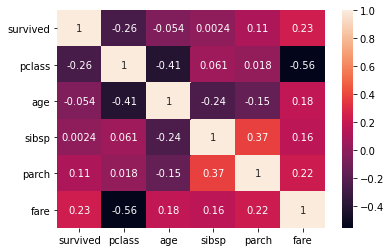

In [164]:
corr_matrix(df,y)

### Detect Outliers 

In [546]:
def detect_outliers(df,std_threshold=5): 
    out_df = pd.DataFrame(df.select_dtypes(include='number').apply(lambda x: x>np.std(x)*std_threshold).sum(),
                 columns=['total']).sort_values('total',ascending=False)

    return out_df[out_df.total > 0]
detect_outliers(df,std_threshold=5)

,total
cabin_D,46
cabin_E,41
cabin_A,22
cabin_F,21
fare,17
age,13
family_size,11
parch,10
sibsp,9


In [536]:
# df[df.select_dtypes(include='number').apply(lambda x: x>np.std(x)*5).any(1)]

In [553]:
df.fare.describe()

count    1309.000000
mean       33.276623
std        51.743377
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: fare, dtype: float64

In [549]:
df.fare[df.fare>np.std(df.fare)*5]

27      263.0000
88      263.0000
258     512.3292
311     262.3750
341     263.0000
438     263.0000
679     512.3292
737     512.3292
742     262.3750
915     262.3750
944     263.0000
950     262.3750
955     262.3750
960     263.0000
1033    262.3750
1234    512.3292
1266    262.3750
Name: fare, dtype: float64

In [575]:
df.age[df.age>np.std(df.age)*5]

33     66.0
54     65.0
96     71.0
116    70.5
280    65.0
456    65.0
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
972    67.0
987    76.0
Name: age, dtype: float64

In [576]:
df.age.describe()

count    1309.000000
mean       29.881138
std        12.883193
min         0.170000
25%        22.000000
50%        29.881138
75%        35.000000
max        80.000000
Name: age, dtype: float64

In [588]:
# sns.barplot(x='age', y='survived', data=df)

In [580]:
df[["age", "survived"]].groupby(["survived"], as_index = False).mean()

,survived,age
0,0,30.367241
1,1,29.079165


In [581]:
df[y][df.age>np.std(df.age)*5] # most people in this group did not make it. 

33     0
54     0
96     0
116    0
280    0
456    0
493    0
630    1
672    0
745    0
851    0
972    0
987    1
Name: survived, dtype: int64

In [584]:
help(sns.factorplot)

Help on function factorplot in module seaborn.categorical:

factorplot(*args, **kwargs)
    Deprecated; please use `catplot` instead.



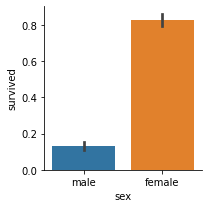

In [586]:
g = sns.catplot(x="sex", y ="survived", data=df, kind="bar", height=3)
plt.show()

## Feature Engineering 

### SEX 

In [ ]:
# genders = {"male": 0, "female": 1}
# df.sex.map(genders)

In [349]:
# tmp = pd.Series([1,2,1])==1
# tmp*1

0    1
1    0
2    1
dtype: int64

In [325]:
# Make Sex numeric feature 
df['is_male'] = df.sex == 'male' *1
features.append('is_male')
print(features)

['is_male']


In [351]:
df.is_male*=1

### EMBARKED 

In [326]:
col_name = "embarked"
features += list(pd.get_dummies(df[col_name],prefix=col_name).columns)
df = pd.get_dummies(df,columns=[col_name],prefix=col_name)
print(features)

['is_male', 'embarked_C', 'embarked_Q', 'embarked_S']


### CABIN

In [336]:
col_name = "cabin"
features += list(pd.get_dummies(df[col_name],prefix=col_name).columns)
df = pd.get_dummies(df,columns=[col_name],prefix=col_name)
print(features)

['is_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'family_size', 'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F', 'cabin_O']


### TITLE 

group the minority group into a special group

In [156]:
df['title'] = [i.split(',')[1].split('.')[0].strip() for i in df.name]
# features.append('title')

In [144]:
df.title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Sir               1
Lady              1
the Countess      1
Don               1
Jonkheer          1
Mme               1
Dona              1
Name: title, dtype: int64

### FAMILY

In [321]:
df.sibsp.value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

In [323]:
df["family_size"] = df.sibsp+df.parch

In [327]:
features.append('family_size')

### Correlation

,survived
survived,1.000000
is_male,-0.688371
pclass,-0.264710
cabin_O,-0.258132
fare,0.233832
cabin_B,0.141251
embarked_S,-0.133020
embarked_C,0.121156
cabin_E,0.113344
cabin_C,0.113088


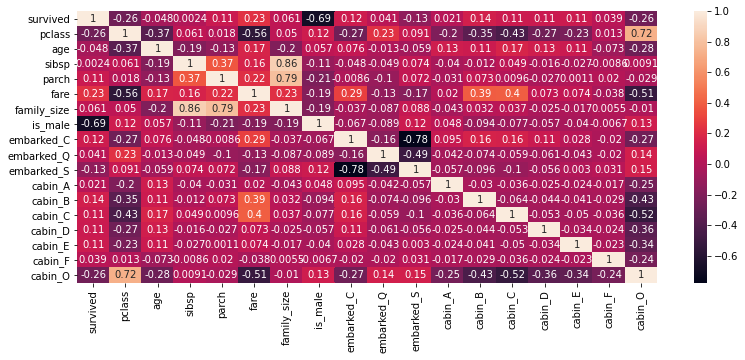

In [589]:
corr_matrix(df,y)

## Model 

In [335]:
df.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'family_size', 'is_male', 'embarked_C', 'embarked_Q',
       'embarked_S'],
      dtype='object')

In [338]:
og_feaures = ['pclass','age','sibsp','parch','fare'] 
new_features = features.copy() 
features = og_feaures + new_features 

### train test split 

In [ ]:
from sklearn.model_selection import train_test_split
# 80 train, 10 test, 10 validation 
x_train, x_test_temp, y_train, y_test_temp = train_test_split(df[features], df[y], test_size=0.20, random_state = 0)
# validation
x_test, x_val, y_test, y_val = train_test_split(x_test_temp, y_test_temp, test_size=0.5, random_state=0)

In [468]:
from sklearn.model_selection import train_test_split
# 80 train, 20
x_train, x_test, y_train, y_test = train_test_split(df[features], df[y], test_size=0.20, random_state=0,stratify=df[y])

In [340]:
x_train.shape,x_test.shape

((1047, 17), (262, 17))

### Baseline - Logistic Regression

In [343]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       1309 non-null   int64  
 1   age          1309 non-null   float64
 2   sibsp        1309 non-null   int64  
 3   parch        1309 non-null   int64  
 4   fare         1309 non-null   float64
 5   is_male      1309 non-null   bool   
 6   embarked_C   1309 non-null   uint8  
 7   embarked_Q   1309 non-null   uint8  
 8   embarked_S   1309 non-null   uint8  
 9   family_size  1309 non-null   int64  
 10  cabin_A      1309 non-null   uint8  
 11  cabin_B      1309 non-null   uint8  
 12  cabin_C      1309 non-null   uint8  
 13  cabin_D      1309 non-null   uint8  
 14  cabin_E      1309 non-null   uint8  
 15  cabin_F      1309 non-null   uint8  
 16  cabin_O      1309 non-null   uint8  
dtypes: bool(1), float64(2), int64(4), uint8(10)
memory usage: 75.5 KB


In [370]:
import statsmodels.api as sm
# logistic regression 
x = x_train
x = sm.add_constant(x)
model = sm.Logit(y_train, x).fit()

Optimization terminated successfully.
         Current function value: 0.372185
         Iterations 7


In [368]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 1047
Model:                          Logit   Df Residuals:                     1032
Method:                           MLE   Df Model:                           14
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:                  0.4309
Time:                        13:11:36   Log-Likelihood:                -389.68
converged:                       True   LL-Null:                       -684.75
Covariance Type:            nonrobust   LLR p-value:                6.668e-117
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.1466        nan        nan        nan         nan         nan
pclass         -0.6366      0.178     -3.576      0.000      -0.986      -0.288
age            -0.0313      0.008     -3.921      0.000      -0.047      -0.016
sibsp          -0.1584    6.4e+06  -2.47e-08      1.000   -1.25e+07    1.25e+07
parch           0.0537    6.4e+06   8.38e-09      1.000   -1.25e+07    1.25e+07
fare            0.0044      0.003      1.690      0.091      -0.001       0.009
is_male        -3.6250      0.210    -17.278      0.000      -4.036      -3.214
embarked_C      1.1975        nan        nan        nan         nan         nan
embarked_Q      1.0334        nan        nan        nan         nan         nan
embarked_S      0.9157        nan        nan        nan         nan         nan
family_size    -0.1047    6.4e+06  -1.63e-08      1.000   -1.25e+07    1.25e+07
cabin_A         0.4715        nan        nan        nan         nan         nan
cabin_B        -0.0718        nan        nan        nan         nan         nan
cabin_C        -0.6132        nan        nan        nan         nan         nan
cabin_D         0.7539        nan        nan        nan         nan         nan
cabin_E         1.4021        nan        nan        nan         nan         nan
cabin_F         1.4088        nan        nan        nan         nan         nan
cabin_O        -0.2047        nan        nan        nan         nan         nan
===============================================================================
"""

In [376]:
x = x_test
x = sm.add_constant(x)
y_pred = model.predict(x)
jj_binary_score(y_test,y_pred)

Scoring 262 observations.
---------------------------
Accuracy : 0.87
ROC AUC  : 0.933
PR AUC   : 0.922
F1 Score : 0.858
Precision: 0.831
Recall   : 0.888


### Random Forest 

In [378]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
# import pydot
# import pydotplus
from IPython.display import display, Image

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


#### v1 

In [404]:
%%time

#rf = RandomForestClassifier(max_depth=20,n_estimators=100,random_state=0)
rf = RandomForestClassifier(n_estimators=100)
# Train the model on training data
rf.fit(x_train, y_train)
# Use the forest's predict method on the test data
# predictions = rf.predict(x_test)
# predict 
y_pred = rf.predict_proba(x_test)

CPU times: user 160 ms, sys: 3.39 ms, total: 164 ms
Wall time: 163 ms


In [400]:
jj_binary_score(y_test,y_pred[:,1])

Scoring 262 observations.
---------------------------
Accuracy : 0.851
ROC AUC  : 0.919
PR AUC   : 0.919
F1 Score : 0.835
Precision: 0.818
Recall   : 0.853


,importance
is_male,0.399336
age,0.205949
fare,0.192666
family_size,0.042488
pclass,0.036389
sibsp,0.024537
parch,0.023411
cabin_O,0.017421
embarked_S,0.012539
embarked_C,0.009854


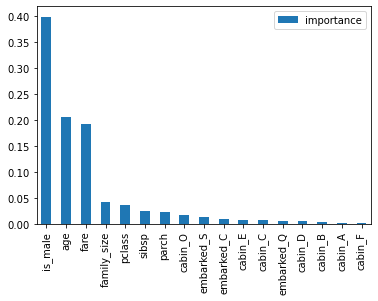

In [409]:
rf_features(rf,features)

#### plot tree 

In [ ]:
tree = rf.estimators_[10]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True,max_depth=10)#, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

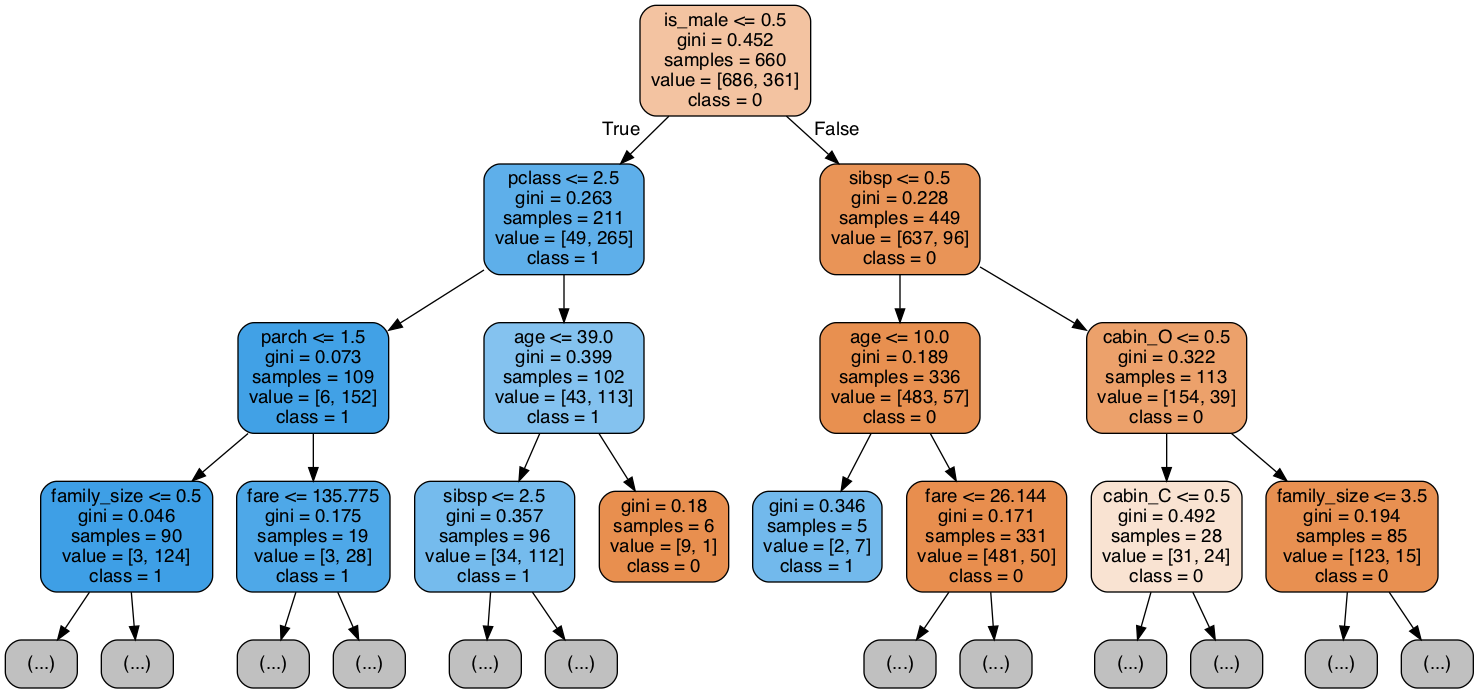

In [574]:
from sklearn.tree import export_graphviz
import pydot
import pydotplus

export_graphviz(tree, 
                out_file = 'tree.dot', 
                feature_names = features, 
                class_names = ['0','1'],
                rounded = True,
                max_depth=3,
                filled=True)#, precision = 1)
graph = pydotplus.graph_from_dot_file('tree.dot')  
graph.write_png('tree2.png')
Image(graph.create_png())

#### cross validation 

In [402]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.9047619  0.81904762 0.82857143 0.81904762 0.81904762 0.83809524
 0.83809524 0.81730769 0.78846154 0.81730769]
Mean: 0.8289743589743589
Standard Deviation: 0.028494607676067357


### Grid Search 

In [597]:
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700]}

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=2)
clf.fit(x_train, y_train)
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 25,
 'n_estimators': 400}

In [419]:
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 400}

In [421]:
rf = RandomForestClassifier(criterion='gini',
                            min_samples_leaf=5,
                            min_samples_split=2,
                            n_estimators=400)
rf.fit(x_train, y_train)
y_pred = rf.predict_proba(x_test)
jj_binary_score(y_test,y_pred[:,1])

Scoring 262 observations.
---------------------------
Accuracy : 0.889
ROC AUC  : 0.939
PR AUC   : 0.937
F1 Score : 0.873
Precision: 0.885
Recall   : 0.862


,importance
is_male,0.592732
fare,0.126130
age,0.084312
family_size,0.043982
pclass,0.042810
cabin_O,0.023131
sibsp,0.021697
parch,0.021493
embarked_S,0.010309
embarked_Q,0.007221


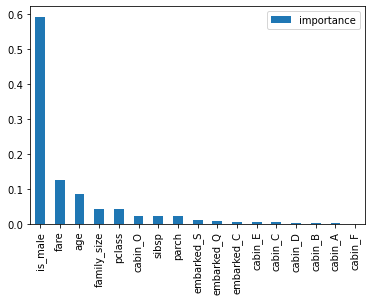

In [422]:
rf_features(rf,features)

### Neural Net 

In [448]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adagrad,SGD,Adadelta,Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

#### standardize 

In [495]:
from sklearn import preprocessing
feature_scaled = preprocessing.scale(df[features])
print('Mean = 0')
print(sum(np.apply_along_axis(lambda x: round(np.mean(x)),0,feature_scaled))==0)

print('\nStandard Deviation = 1')
print(all(np.apply_along_axis(lambda x: round(np.std(x)),0,feature_scaled)==1))

Mean = 0
True

Standard Deviation = 1
True


In [496]:
from sklearn.model_selection import train_test_split
# 80 train, 20
x_train, x_test, y_train, y_test = train_test_split(feature_scaled, df[y], test_size=0.20, random_state=0,stratify=df[y])

In [515]:
batch_size = 128
epochs = 15

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks = [early_stopping]
           )

score = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', round(score[0],5))
# print('Test accuracy:', round(score[1],5))

# y_pred = model.predict_proba(x_test)
# print('AUC:', round(roc_auc_score(y_test, y_pred),5))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 128)               2304      
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
9/9 [==============================] - 0s 11ms/step - loss: 0.6683 - accuracy: 0.5969 - val_loss: 0.5712

In [503]:
y_pred = model.predict(x_test)
jj_binary_score(y_test,y_pred)

Scoring 262 observations.
---------------------------
Accuracy : 0.874
ROC AUC  : 0.92
PR AUC   : 0.894
F1 Score : 0.834
Precision: 0.83
Recall   : 0.838


In [517]:
history.history

{'loss': [0.6682811379432678,
  0.5460492372512817,
  0.47661447525024414,
  0.4443168342113495,
  0.4049105644226074,
  0.397697776556015,
  0.38784337043762207,
  0.39672189950942993,
  0.3746309280395508,
  0.37674546241760254,
  0.37230271100997925,
  0.36435309052467346,
  0.3586832880973816,
  0.37375393509864807,
  0.3651895523071289],
 'accuracy': [0.5969436764717102,
  0.7297039031982422,
  0.7975167036056519,
  0.826170027256012,
  0.8462272882461548,
  0.8481375575065613,
  0.8510028719902039,
  0.850047767162323,
  0.856733500957489,
  0.8519579768180847,
  0.8548232913017273,
  0.8605539798736572,
  0.8662846088409424,
  0.8605539798736572,
  0.856733500957489],
 'val_loss': [0.5712368488311768,
  0.48948222398757935,
  0.43486496806144714,
  0.3991389870643616,
  0.3780534267425537,
  0.36100855469703674,
  0.35439133644104004,
  0.34145355224609375,
  0.34046471118927,
  0.3388282060623169,
  0.3326379656791687,
  0.33023419976234436,
  0.3309789299964905,
  0.3329379260

In [512]:
import os 

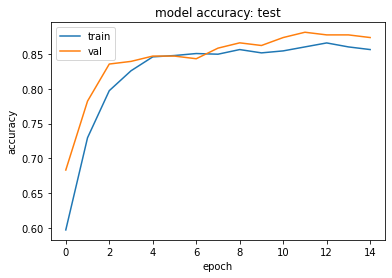

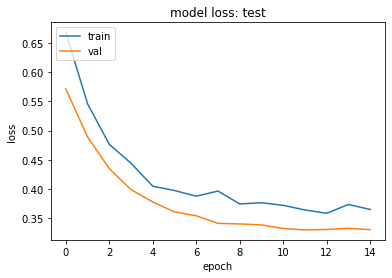

In [518]:
def plot_history(history,file_unique_name,directory):

    '''
    history: model.fit object 
    file_unique_name: name to save the image 
    directory: directory to save the image 
    '''

    # plot accuracy and loss curve 
    ## summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy: %s' % file_unique_name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
        
    save_path = os.path.join(directory,'%s_accuracy.png' % (file_unique_name))
    
#     save_path = '%s' % (directory,file_unique_name,)
    plt.savefig(save_path)
    plt.show()
    plt.close()
    ## summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss: %s' % file_unique_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    save_path = os.path.join(directory,'%s_loss.png' % (file_unique_name))
    plt.savefig(save_path)
#     plt.savefig('3_Model_Training/results/figs/%s_loss.png' % (file_unique_name))
    plt.show()
    plt.close()
    
plot_history(history,'test','')

## Evaluation